In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import torch

from data_reconstruct import *
from data_reconstruct.backend import *
from data_reconstruct.examples import *
from data_reconstruct.utilities import *

In [3]:
random_state = 42
np.random.seed(random_state)

# Load Data

In [4]:
# Read
mod1 = pd.read_csv('data/decennial_2020_nov8GAN.csv')[1:]
mod2 = pd.read_csv('data/public_150k_plus_210630.csv')
mod1_tagged = process_decennial(mod1)
mod2_tagged = process_ppp(mod2)
mod1, mod1_cols, mod1_tags_cols = mod1_tagged
mod2, mod2_cols, mod2_tags_cols = mod2_tagged

# Merge
mod1, mod2, annotations = merge_data(mod1_tagged, mod2_tagged, agg_by_tag=True)

# Sample
num_samples = min(mod1.shape[0], 2000)
mod1_sample = mod1.sample(num_samples, random_state=random_state)
mod2_sample = mod2.sample(num_samples, random_state=random_state)
annotations_sample = annotations.sample(num_samples, random_state=random_state);

# Predict Excluded Records

In [5]:
predicted_feature = 3

split_idx = int(.8 * len(mod2_sample))
pipeline_output = run_pipeline(
    mod1_sample.to_numpy(),
    mod2_sample.to_numpy(),
    train_idx=split_idx,
    output_cols=[predicted_feature],
    # std_function_and_inv=(lambda x: x**3, lambda x: x**(1/3)),
    embedding_dim=50,
    embedding_kwargs={
        'project_mode': 'tsne',
        'epoch_pd': 1000,
        'log_pd': 500,
        'epoch_DNN': 100,
        'log_DNN': 100,
    },
    hidden_dim=20,
    nn_kwargs={
        'epochs': 50,
        'log_epoch': 50,
        # 'criterion': torch.nn.L1Loss(),
        # 'optimizer': lambda x: torch.optim.AdamW(x, lr=1e-6),
    },
)

use random seed: 666
Shape of Raw data
Dataset 0: (462, 6)
Dataset 1: (369, 9)
---------------------------------
Find correspondence between Dataset 1 and Dataset 2
use device: cpu
epoch:[500/1000] err:0.3802 alpha:1.3430
epoch:[1000/1000] err:0.4047 alpha:1.5287
Finished Matching!
---------------------------------
Begin finding the embedded space
epoch:[100/100]: loss:1.794544, align_loss:0.236449
Done
---------------------------------
unionCom Done!
time: 6.747562408447266 seconds
---------------------------------
Mapping to last dataset...
Epoch:  50    Loss:  0.00286
Validation Loss: 0.00234


# Evaluate Results

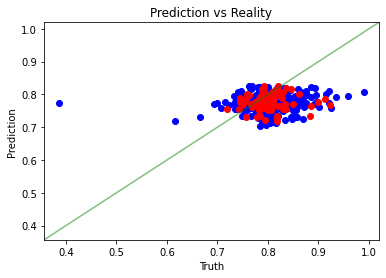

In [6]:
plot_example_results(mod2_sample.iloc[:, predicted_feature], pipeline_output, split_idx)